In [1]:
from torch_geometric import nn as gnn
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.manifold import TSNE
import seaborn as sns
from torch_geometric.loader import LinkNeighborLoader
import torch
import torch.nn.functional as F
import imageio
import warnings
warnings.filterwarnings('ignore')
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo
import plotly.io as pio
pio.renderers.default = 'iframe'
import wandb
from pipeline import GraphSage
import pytorch_lightning as pl
from lightning.pytorch.loggers import WandbLogger
from AutoEncoders import GAE, VGAE
from Wrappers import AutoEncoderWrapper
from DirectedWeightedGCN import DirWGCN, DirGCNConv
from utils import get_norm_adj
from torch_sparse import SparseTensor

In [2]:
# A = pd.read_csv(
#     'C:/Users/geras/OneDrive/Рабочий стол/c01/RetentioneeRing/adj_matrix.csv', 
#     index_col = 'Unnamed: 0'
# )

# name_to_index = {}
# for i, col in enumerate(A.columns):
#     name_to_index[col] = i

# index_to_name = {}
# for i, col in enumerate(A.columns):
#     index_to_name[i] = col

# A_np = A.to_numpy()

# row, col = np.where(A_np>0)
# edge_weight = torch.tensor(A_np[row, col], dtype = torch.float32)

# edge_index = torch.tensor(np.array([row, col]), dtype = torch.long)

# freatures_num = 5
# x = torch.tensor(np.random.normal(0,1, size = (len(A.columns),freatures_num)), dtype = torch.float32)

In [3]:
wandb.login()

wandb: Currently logged in as: gerasimov-serf (zimran-c01-hack). Use `wandb login --relogin` to force relogin


True

In [4]:
data = Planetoid(root = './data/Planetoid', name='Cora')[0]

In [5]:
np.random.seed(42)
w = torch.Tensor(np.random.uniform(0, 1, data.edge_index.shape[1]))

In [6]:
data.edge_weight = w

In [7]:
class DecodeMLP(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.lin = [nn.Linear(2*in_channels, hidden_channels)]
        for i in range(num_layers-1):
            self.lin.append(nn.Linear(hidden_channels, hidden_channels))
        self.lin.append(nn.Linear(hidden_channels, 1))
        self.lin = nn.ModuleList(self.lin)
        self.activation = nn.GELU()
        
    def forward(self, z, edge_index):
        z_src, z_dst = z[edge_index[0]], z[edge_index[1]]
        x = torch.cat([z_src, z_dst], dim=1)
        for j in range(self.num_layers-1):
            x = self.lin[j](x)
            x = self.activation(x)
        return F.sigmoid(self.lin[-1](x)).squeeze()

# AutoEncoder on VAE/GAE

In [8]:
# Note, that decoder should not be symmetric as graph is directed

In [30]:
project, name, in_channels, hidden_channels, out_channels, num_layers = 'AutoEncoders', 'VGAE test 17', data.x.shape[1], 128, 64, 4
encoder = DirWGCN(in_channels, hidden_channels, out_channels, num_layers, head_num = 2)
decoder = DecodeMLP(out_channels, hidden_channels, num_layers)
config = {
    'in_channels': in_channels,
    'hidden_channels': hidden_channels,
    'out_channels': out_channels,
    'num_layers' : num_layers
}

In [31]:
model = AutoEncoderWrapper(project, name, config, encoder, decoder, model = 'VGAE', loss_type = 'MSE', device = 'cuda')

In [32]:
model.fit(data,epochs_num = 500, lr=0.005, lambda_=None)

KL Loss,▄▁▅▇▇█▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Train Loss (MSE),█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
KL Loss,5.66211
Train Loss (MSE),0.08542
epoch,500
step,500


In [21]:
z = model(data.x, data.edge_index, data.edge_weight).to('cpu')

In [22]:
data.edge_index, data.edge_weight

(tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
         [   0,    0,    0,  ..., 2707, 2707, 2707]], device='cuda:0'),
 tensor([0.3745, 0.9507, 0.7320,  ..., 0.5834, 0.7500, 0.5099], device='cuda:0'))

In [23]:
torch.mean((model.decoder(z.to('cuda'), data.edge_index.to('cuda')) - data.edge_weight)**2), 

(tensor(0.0860, device='cuda:0', grad_fn=<MeanBackward0>),)

In [24]:
torch.mean(torch.abs(model.decoder(z.to('cuda'), data.edge_index.to('cuda')) - data.edge_weight)), 

(tensor(0.2479, device='cuda:0', grad_fn=<MeanBackward0>),)

In [25]:
model.decoder(z.to('cuda'), data.edge_index.to('cuda'))

tensor([0.5789, 0.5867, 0.5864,  ..., 0.5030, 0.5597, 0.5692], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

In [26]:
data.edge_weight

tensor([0.3745, 0.9507, 0.7320,  ..., 0.5834, 0.7500, 0.5099], device='cuda:0')

In [27]:
tsne = TSNE()

In [28]:
z_pr = tsne.fit_transform(z)

<Axes: >

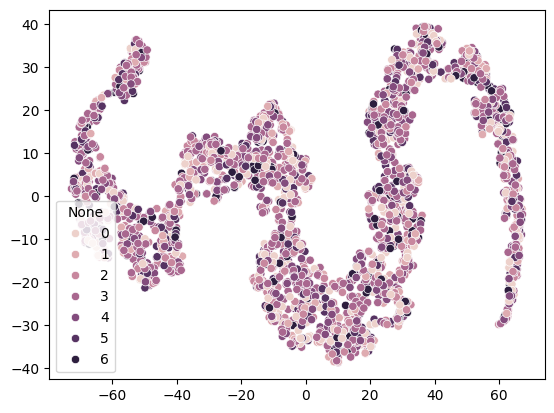

In [29]:
sns.scatterplot(x = z_pr[:,0], y = z_pr[:,1], hue = data.y.cpu())

In [9]:
class LitDirWGCNAutoEncoder(pl.LightningModule):
    def __init__(self, project, name, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0,
                 jumping_knowledge='max', normalize=False,alpha=0.5,learn_alpha=False,bias=True,activation=nn.ReLU, 
                 autoencoder='VGAE', decoder = None, lr = 0.01, lambda_=None):
        super().__init__()
        
        # log hyperparameters
        self.save_hyperparameters()
        self.project, self.name = project, name
        self.config = {
            'in_channels' : in_channels, 
            'hidden_channels' : hidden_channels, 
            'out_channels' : out_channels, 
            'num_layers' : num_layers,
            'dropout' : dropout,
            'jumping_knowledge' : jumping_knowledge,
            'normalize': normalize,
            'alpha' : alpha, 
            'learn_alpha' : learn_alpha,
            'bias': bias,
            'activation' : activation,
            'autoencoder':autoencoder,
            'lr' : lr,
        }
        self.lambda_ = lambda_
        self.autoencoder = autoencoder
        if autoencoder == 'GAE':
            head_num = 1
        else:
            head_num = 2
            
        self.encoder = DirWGCN(in_channels, hidden_channels, out_channels, num_layers, dropout, jumping_knowledge, normalize,
                               alpha, learn_alpha, bias, activation, head_num)
        self.decoder = decoder
        if autoencoder == 'GAE':
            self.autoenc = GAE(self.encoder, self.decoder)
        else:
            self.autoenc = VGAE(self.encoder, self.decoder)
         
        
    def forward(self, x, edge_index, edge_weight):
        return self.autoenc.encode(x, edge_index, edge_weight)
        
    def training_step(self, batch, batch_idx):
        z = self(batch.x, batch.edge_index, batch.edge_weight)
        
        loss = self.autoenc.recon_loss(z, data.edge_index, data.edge_weight)
        if self.autoencoder == 'VGAE':
            if self.lambda_ == None:
                loss = loss + (1/batch.num_nodes) * self.autoencoder.kl_loss()
            else:
                loss = loss + self.lambda_ * self.autoencoder.kl_loss()
        
        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        return loss
        
    # def validation_step(self, batch, batch_idx):
    #     x, y = batch
    #     logits = self(x)
    #     loss = F.cross_entropy(logits, y)

    #     # validation metrics
    #     preds = torch.argmax(logits, dim=1)
    #     acc = self.accuracy(preds, y)
    #     self.log('val_loss', loss, prog_bar=True)
    #     self.log('val_acc', acc, prog_bar=True)
    #     return loss
    # def test_step(self, batch, batch_idx):
    #     x, y = batch
    #     logits = self(x)
    #     loss = F.cross_entropy(logits, y)
        
    #     # validation metrics
    #     preds = torch.argmax(logits, dim=1)
    #     acc = self.accuracy(preds, y)
    #     self.log('test_loss', loss, prog_bar=True)
    #     self.log('test_acc', acc, prog_bar=True)
    #     return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config['lr'])
        return optimizer

In [10]:
# project = 'AutoEncoders'
# name = 'VGAE test 1'
# model = LitDirWGCNAutoEncoder(project, name, data.x.shape[1], 128, 64)

# # Initialize wandb logger
# wandb_logger = WandbLogger(project=project, name = name+' Lite',job_type='train')
# # Initialize Callbacks
# early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss")
# checkpoint_callback = pl.callbacks.ModelCheckpoint()
# trainer = pl.Trainer(max_epochs=50,
#                      logger=wandb_logger,
#                      callbacks=[early_stop_callback,
#                                 checkpoint_callback],
#                      devices = 'cpu'
#                      )

In [11]:
loader = LinkNeighborLoader(data, num_neighbors = [30]*2)

In [12]:
# Train the model
trainer.fit(model = model, train_dataloaders = loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | DirWGCN | 449 K 
1 | autoenc | VGAE    | 449 K 
------------------------------------
449 K     Trainable params
1         Non-trainable params
449 K     Total params
1.799     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/10556 [00:00<?, ?it/s] 

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [10]:
config = {
    'n_channels': data.x.shape[1],
    'hidden_channels': 128,
    'out_channels': 64 
}

In [11]:
vgae_test = AutoEncoderWrapper(data, 'AutoEncoders', 'VGAE 1.0 test', config, encoder, autoencoder='GAE') 

In [12]:
loader = LinkNeighborLoader(data, num_neighbors=[30] * 2, batch_size=128, edge_label_index=data.edge_index)

# Dir-GraphSAGE

In [5]:
class DirSageConv(nn.Module):
    def __init__(self, input_dim, output_dim, alpha):
        super(DirSageConv, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.conv_src_to_dst = gnn.SAGEConv(input_dim, output_dim, flow="source_to_target", root_weight=False)
        self.conv_dst_to_src = gnn.SAGEConv(input_dim, output_dim, flow="target_to_source", root_weight=False)
        self.lin_self = nn.Linear(input_dim, output_dim)
        self.alpha = alpha

    def forward(self, x, edge_index):
        return (
            self.lin_self(x)
            + (1 - self.alpha) * self.conv_src_to_dst(x, edge_index)
            + self.alpha * self.conv_dst_to_src(x, edge_index)
        )

In [6]:
class DirSAGE(nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
        num_layers=3,
        dropout=0,
        jumping_knowledge='max',
        normalize=False,
        alpha=1 / 2,
        learn_alpha=False,
    ):
        super().__init__()

        self.alpha = nn.Parameter(torch.ones(1) * alpha, requires_grad=learn_alpha)
        if num_layers == 1:
            self.convs = nn.ModuleList([DirSageConv(in_channels, output_dim, self.alpha)])
        else:
            self.convs = nn.ModuleList([DirSageConv(in_channels, hidden_channels, self.alpha)])
            for _ in range(num_layers - 2):
                self.convs.append(DirSageConv(hidden_channels, hidden_channels, self.alpha))
            self.convs.append(DirSageConv(hidden_channels, hidden_channels, self.alpha))

        if jumping_knowledge is not None:
            input_dim = hidden_channels * num_layers if jumping_knowledge == "cat" else hidden_channels
            self.lin = nn.Linear(input_dim, out_channels)
            self.jump = gnn.JumpingKnowledge(mode=jumping_knowledge, channels=hidden_channels, num_layers=num_layers)

        self.num_layers = num_layers
        self.dropout = dropout
        self.jumping_knowledge = jumping_knowledge
        self.normalize = normalize

    def forward(self, x, edge_index):
        xs = []
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != len(self.convs) - 1 or self.jumping_knowledge:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
                if self.normalize:
                    x = F.normalize(x, p=2, dim=1)
            xs += [x]
        if self.jumping_knowledge is not None:
            x = self.jump(xs)
            x = self.lin(x)

        return x #torch.nn.functional.log_softmax(x, dim=1)

In [7]:
class DirGraphSage:
    def __init__(self, dataset, project, name, in_channels, hidden_channels, out_channels,
                 num_layers,
                 dropout = 0, 
                #  act = "relu",
                #  act_first = False,
                # act_kwargs = None,
                norm = None,
                # norm_kwargs = None,
                jumping_knowledge = 'max',
                normalize=False,
                alpha=1 / 2,
                learn_alpha = False,
                device = 'cuda', #add GraphSageConv kargs
                ):
        self.dataset = dataset
        self.project, self.name = project, name
        self.config = {
            'in_channels' : in_channels, 
            'hidden_channels' : hidden_channels, 
            'num_layers' : num_layers, 
            'out_channels' : out_channels,
            'dropout' : dropout, 
            # 'act' : act,
            # 'act_first' : act_first,
            # 'act_kwargs' : act_kwargs,
            'normalize' : normalize,
            'alpha' : alpha,
            'learn_alpha' : learn_alpha,
            # 'norm_kwargs' : norm_kwargs,
            'jumping_knowledge' : jumping_knowledge,
            'device' : device,
            # 'graphsage_conv_args' : graphsage_conv_kargs
        }
        self.device = device

        
    def fit(self, epochs_num = 100, lr=0.005, optimizer = torch.optim.Adam, optimizer_args = {}, 
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau, scheduler_args = {}, batch_size = 64, num_neighbors = [30] * 2, neg_sampling_ratio = 1.0,
            compiled = False):
            
        self.config['epochs_num'] = epochs_num
        self.config['lr'] = lr
        self.config['optimizer'] = optimizer.__name__
        self.config['scheduler'] = scheduler.__name__
        self.config['optimizer_args'] = optimizer_args
        self.config['scheduler_args'] = scheduler_args
        self.config['batch_size'] = batch_size
        self.config['num_neighbors'] = num_neighbors
        self.config['neg_sampling_ratio'] = neg_sampling_ratio
        
        with wandb.init(project=self.project, name=self.name, config=self.config):
            config = wandb.config
            
            self.dirgraphsage = DirSAGE(
                                in_channels = config.in_channels, 
                                hidden_channels = config.hidden_channels, 
                                num_layers = config.num_layers, 
                                out_channels = config.out_channels,
                                dropout = config.dropout, 
                                # act = config.act,
                                # act_first = config.act_first,
                                # act_kwargs = config.act_kwargs,
                                normalize = config.normalize,
                                alpha = config.alpha,
                                learn_alpha = config.learn_alpha,
                                # norm_kwargs = config.norm_kwargs,
                                jumping_knowledge = config.jumping_knowledge,
                                # **config.graphsage_conv_args
                            ).to(self.device)
            
            if compiled:
                self.dirgraphsage = torch.compile(self.dirgraphsage)
                
            self.dirgraphsage.train()
            
            loader = LinkNeighborLoader(self.dataset, batch_size = config.batch_size, shuffle=True,
                            neg_sampling_ratio=config.neg_sampling_ratio, num_neighbors=config.num_neighbors,
                            num_workers=6, persistent_workers=True)
            
            optim = optimizer(self.dirgraphsage.parameters(), lr = config.lr, **config.optimizer_args)
            scheduler = scheduler(optim, **config.scheduler_args)
            batch_count = 0
            
            wandb.watch(self.dirgraphsage, log="gradients", log_freq=10)
    
            for epoch in range(1, config.epochs_num+1):
                total_loss = total_examples = 0
                for data in loader:
                    data = data.to(self.device)
                    h = self.dirgraphsage(data.x, data.edge_index)

                    h_src = h[data.edge_label_index[0]]
                    h_dst = h[data.edge_label_index[1]]
                    link_pred = (h_src * h_dst).sum(dim=-1)  # Inner product.
            
                    loss = F.binary_cross_entropy_with_logits(link_pred, data.edge_label)
                    
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    
                    batch_count+=1
                    total_loss += float(loss) * link_pred.numel()
                    total_examples += link_pred.numel()
            
                loss_final = total_loss / total_examples
                wandb.log({"epoch": epoch, "loss GS": loss_final, "step" : batch_count})
                try:
                    scheduler.step(loss_final)
                except:
                    scheduler.step()       
        return self  
            
    def __call__(self, x, edge_index):
        self.dirgraphsage.eval()
        x, edge_index =  x.to(self.device), edge_index.to(self.device)
        with torch.no_grad():
            return self.dirgraphsage(x, edge_index)

In [8]:
model = DirGraphSage(data, project = 'Node2Vec vs GCN AutoEncoder', name = 'Dir_GraphSAGE' , 
                     in_channels = data.x.shape[1], hidden_channels = 256, out_channels = 128,
                     num_layers = 3)

In [9]:
model.fit()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss GS,█▆▄▄▄▄▃▄▄▄▄▃▂▂▂▂▂▂▂▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,100
loss GS,0.40791
step,16500


In [10]:
wandb.finish()

# GraphSage

In [5]:
model = GraphSage(data, project ='Node2Vec vs GCN AutoEncoder' , name = 'GraphSage 3.0 max', 
                  in_channels = data.x.shape[1], hidden_channels = 200, num_layers = 10, out_channels = 128, jk  = 'max')

In [6]:
model.fit(epochs_num=300, compiled = False, batch_size=256)

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss GS,█▇▅▄▅▅▂▂▁▂▂▂▂▁▂▂▂▁▁▂▁▂▂▁▂▁▁▁▂▂▂▂▁▁▁▂▁▂▁▂
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch,300
loss GS,0.39545
step,12600


In [7]:
z = model(data.x, data.edge_index).cpu().numpy()

In [8]:
z.shape

(2708, 128)

In [9]:
%%time
tsne = TSNE(n_components=3)
z_proj = tsne.fit_transform(z)

CPU times: total: 1min 36s
Wall time: 40.3 s


In [10]:
fig = px.scatter_matrix(
    z_proj,

    dimensions=range(3),
    color=data.y
    
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [11]:
wandb.init(project ='Node2Vec vs GCN AutoEncoder' , name = 'GraphSage 3.0 max TSNE')

In [12]:
wandb.log({'tsne GraphSAGE max':fig})

<Axes: >

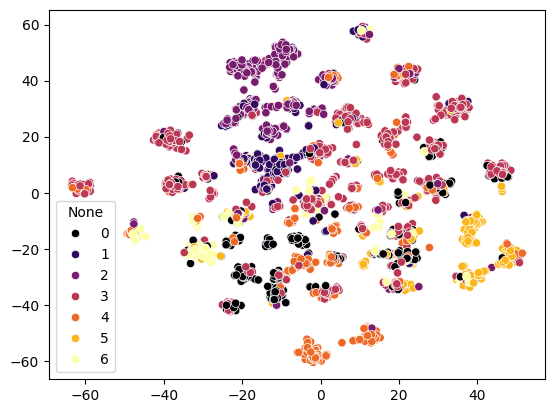

In [27]:
fig = plt.figure()
sns.scatterplot(x = z_proj[:,0], y = z_proj[:,1], hue = data.y, palette = 'inferno')


In [87]:
import networkx as nx
G = nx.Graph()

In [88]:
G.add_edges_from(data.edge_index.T.numpy())

In [97]:
edge[0]

0

In [115]:
G.number_of_edges()

5278

In [118]:
wandb.finish()

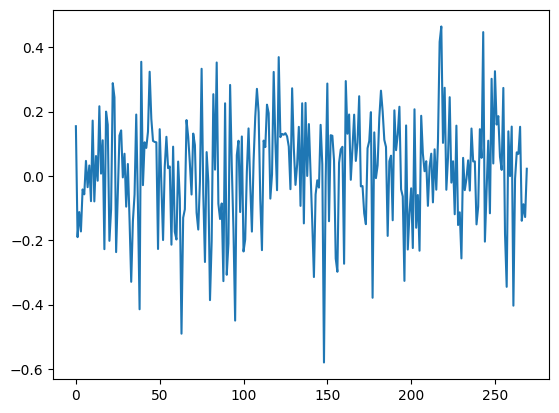

In [57]:
for i in range(1):
    plt.plot(z[:270, 10])

In [ ]:
# config = {
#     'num_features' : data.x.shape[1], 
#     'hidden_dim' : 128, 
#     'num_layers' : 3, 
#     'output_dim' : 64,
#     'dropout' : 0, 
#     'jumping_knowledge': 'max',
#     'normalize': False,
#     'alpha' : 0.5,
#     'learn_alpha' : False,
#     'epochs_num' : 15,
#     'lr' : 0.005,
#     'optimizer' : torch.optim.Adam,
#     'scheduler' : torch.optim.lr_scheduler.ReduceLROnPlateau,
#     'optimizer_args' : {},
#     'scheduler_args' : {},
#     'batch_size' : 64,
#     'num_neighbors' : [30]*2,
#     'neg_sampling_ratio' : 1.0
#     }

In [36]:
#class LiteDirSage(pl.LightningModule):
#     def __init__(self, config):
#         super().__init__()
#         self.save_hyperparameters()
#         self.config = config
#         self.dirsage = DirSAGE(num_features = config['num_features'],
#                         hidden_dim = config['hidden_dim'],
#                         output_dim = config['output_dim'],
#                         num_layers = config['num_layers'],
#                         dropout = config['dropout'],
#                         jumping_knowledge = config['jumping_knowledge'],
#                         normalize = config['normalize'],
#                         alpha = config['alpha'],
#                         learn_alpha = config['learn_alpha']
#                          )
        
#     def forward(self, x, edge_index):
#         return self.dirsage(x, edge_index)

#     def training_step(self, batch, batch_idx):
        
#         h = self(batch.x, batch.edge_index)

#         h_src = h[batch.edge_label_index[0]]
#         h_dst = h[batch.edge_label_index[1]]
#         link_pred = (h_src * h_dst).sum(dim=-1)  # Inner product.

#         loss = F.binary_cross_entropy_with_logits(link_pred, batch.edge_label)
                    
#         # optim.zero_grad()
#         # loss.backward()
#         # optim.step()
        
#         # batch_count+=1
#         total_loss = loss# * link_pred.numel()
#         total_examples = link_pred.numel()
        
#         #************************
#         # training metrics
#         # preds = torch.argmax(logits, dim=1)
#         # acc = self.accuracy(preds, y)
#         #*************************
#         #self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
#         # self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
#         self.log('loss', total_loss)
#         return {'loss' : total_loss, 'total_examples':total_examples}

#     def training_step_end(self, batch_parts):
#     # predictions from each GPU
#         total_examples =  torch.sum(batch_parts["total_examples"])
#         total_loss = torch.sum(batch_parts["loss"])
#         loss_final = total_loss / total_examples
#         self.log('loss GS', loss_final)
#         # do something with both outputs
#         return loss_final
#     def configure_optimizers(self):
#         optimizer = self.config['optimizer'](self.parameters(), lr=self.config['lr'], **self.config['optimizer_args'])
#         scheduler = self.config['scheduler'](optimizer, **self.config['scheduler_args'])
#         return [optimizer], [{"scheduler": scheduler, "monitor": 'loss'}]
            

array([-0.03014549, -0.0255679 , -0.06832502,  0.05494023,  0.0450928 ,
        0.05322916, -0.12394413, -0.00798779,  0.01193796, -0.04459777],
      dtype=float32)

In [ ]:
# wandb.finish()
# wandb_logger = WandbLogger(project='Node2Vec vs GCN AutoEncoder', name = 'Dir_GraphSAGE_Lite', job_type='train')

# trainer = pl.Trainer(max_epochs=config['epochs_num'], logger=wandb_logger)
# trainer.fit(model=model, train_dataloaders=loader)